# import data and package

In [ ]:
# import the packages
import pandas as pd
import numpy as np
import os
import re
import zipfile
import matplotlib.pyplot as plt
import string
import nltk
import joblib
import random
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
train_csv = 'twitter_training.csv'
test_csv = 'twitter_validation.csv'
train_data = pd.read_csv(train_csv, sep = ",", header=None)
test_data = pd.read_csv(test_csv, sep = ",", header=None)

In [ ]:
train_data.columns = ['id', 'company', 'sentiment', 'text']
test_data.columns = ['id', 'company', 'sentiment', 'text']

In [ ]:
train_data.head(1)

,id,company,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...


In [ ]:
train_df = train_data.iloc[:, [2, 3]]
test_df = test_data.iloc[:, [2, 3]]

In [ ]:
# Drop rows with missing values
train_df_cleaned = train_df.dropna()

# Drop duplicate rows based on the 'text' column
train_df_cleaned = train_df_cleaned.drop_duplicates(subset="text")


train_df = train_df_cleaned

# data preprocessing


In [ ]:
def preprocess_df(df):
    def process_string(x):
        # tokenize
        words = nltk.word_tokenize(' '.join([char for char in x.strip().split(" ") if char not in string.punctuation]).lower())

        # stemmization and remove stopwords
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english') and word.isalpha()]

        # regular expression
        words = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), words))
        words = ' '.join(words)

        # lowercase
        words = words.lower()
        return words

    df['text'] = df['text'].apply(process_string)

    return df

In [ ]:
train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)

<ipython-input-8-c1362eef75df>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(process_string)


In [ ]:
train = train_df["text"]
target = train_df["sentiment"]
test = test_df["text"]
test_label = test_df["sentiment"]

In [ ]:
label_encoder = LabelEncoder()

target = label_encoder.fit_transform(target)
test_label = label_encoder.transform(test_label)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


In [ ]:
def tfidf_vectorizer(train, target, test=None, test_size=0.2, random_state=42):
    # Split the train data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=test_size, random_state=random_state)

    # Initialize TfidfVectorizer and fit on the training data
    tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 1), analyzer="word",
                            max_df=0.5, binary=False, token_pattern=r'\w+', sublinear_tf=False)

    # Fit the vectorizer on the training data and transform both training and validation sets
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_val_tfidf = tfidf.transform(X_val)

    # If test data is provided, transform it using the trained TfidfVectorizer
    if test is not None:
        X_test_tfidf = tfidf.transform(test)
        return X_train_tfidf, X_val_tfidf, y_train, y_val, X_test_tfidf, tfidf
    else:
        return X_train_tfidf, X_val_tfidf, y_train, y_val , tfidf


In [ ]:
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf, X_test_tfidf, tfidf = tfidf_vectorizer(train, target, test)
y_test = joblib.load('y_test.joblib')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()

# Input layer
model.add(Dense(1024, activation='relu', input_shape=(X_train_tfidf.shape[1],)))

# Hidden layer 1
model.add(Dense(256, activation='relu'))

# Dropout to avoid overfitting
model.add(Dropout(0.5))

# Hidden layer 2
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))


# Output layer (Assuming multi-class classification with softmax)
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tfidf, y_train_tfidf,
                    epochs=4,
                    batch_size=32,
                    validation_data=(X_val_tfidf, y_val_tfidf))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_tfidf, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/4
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 262s 150ms/step - accuracy: 0.5525 - loss: 1.0364 - val_accuracy: 0.8717 - val_loss: 0.3842
Epoch 2/4
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 261s 150ms/step - accuracy: 0.9354 - loss: 0.2077 - val_accuracy: 0.9178 - val_loss: 0.2587
Epoch 3/4
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 266s 153ms/step - accuracy: 0.9718 - loss: 0.0843 - val_accuracy: 0.9227 - val_loss: 0.2828
Epoch 4/4
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 266s 153ms/step - accuracy: 0.9788 - loss: 0.0595 - val_accuracy: 0.9230 - val_loss: 0.3058
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9636 - loss: 0.1287
Test accuracy: 96.40%


## performance

In [ ]:
# Get predictions (convert probabilities to class labels)
y_pred_probs = model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_probs, axis=1)  # Choose the class with the highest probability


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


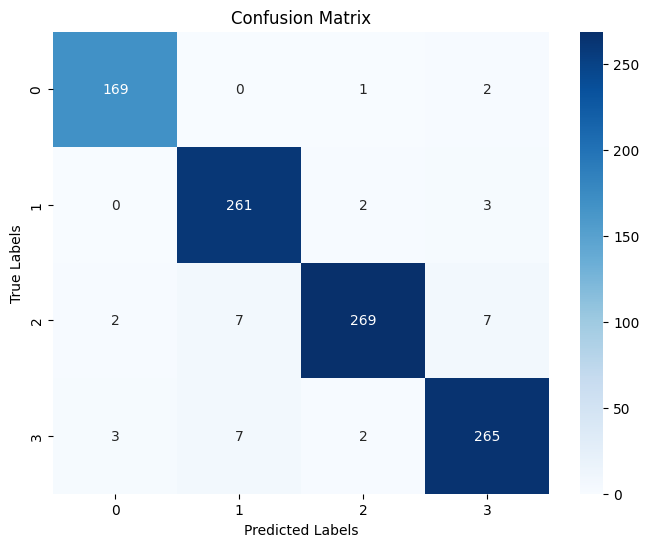

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       172
           1       0.95      0.98      0.96       266
           2       0.98      0.94      0.96       285
           3       0.96      0.96      0.96       277

    accuracy                           0.96      1000
   macro avg       0.96      0.97      0.97      1000
weighted avg       0.96      0.96      0.96      1000

